### Three compartment kinetic model

Context:
- Simulating symmetry breaking by starting from a two compartment model (no plasma membrane enrichment) and increasing plasma membrane affinity at time=0
- Rates modelled using transition state theory (see paper)

Results:
- Whilst increasing dimerisation favours increased plasma membrane assocition in the final _equilibrium_ state, it increses the time to reach this state for two reasons:
    - Slowed membrane exchange kinetics
    - Increased internal membrane association in the initial state
- This has the efffect that, at intermediate timepoints, plasma membrane association is maximised when dimerisation strength is intermediate

Dependencies:
- The kinetic prefactor was calculated in _Prefactor.ipynb_


In [1]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.offsetbox import AnchoredOffsetbox, TextArea, VPacker
from matplotlib.ticker import FuncFormatter
from scipy.integrate import odeint
from scipy.optimize import minimize

from src import fake_log, lighten

%matplotlib inline

mpl.rcParams["figure.dpi"] = 150

if not os.path.exists("Figs"):
    os.mkdir("Figs")

In [2]:
# Model parameters
svr = 0.174 / 2
D = 0.005
dosage = 1.04e-8 / (1 - 0.62)
pf = 43.078077317410866  # see prefactor notebook

### Equilibrium model

In [3]:
def concentration_tree(d, cfrac_smfrac):
    """
    d = total protein

    Concentrations described by a series of fractions (0-1)

    c (cfrac)
    s
        m (smfrac)
        n

    """

    cfrac, smfrac = [1 / (1 + np.exp(-i)) for i in cfrac_smfrac]
    c = d * cfrac
    s = d * (1 - cfrac)
    m = s * smfrac / (svr * D)
    n = s * (1 - smfrac) / (svr * D)
    return c, m, n  # concentrations


def calc_loss(cfrac_smfrac, dosage, ka, km, kn):
    # Concentrations
    c, m, n = concentration_tree(dosage, cfrac_smfrac)

    # Chemical potentials
    muc = np.log(c) - 0.5 * np.log(1 + 4 * ka * c + np.sqrt(1 + 8 * ka * c))
    mum = (
        np.log(m) - 0.5 * np.log(1 + 4 * ka * m + np.sqrt(1 + 8 * ka * m)) - np.log(km)
    )
    mun = (
        np.log(n) - 0.5 * np.log(1 + 4 * ka * n + np.sqrt(1 + 8 * ka * n)) - np.log(kn)
    )

    # Loss
    mu_all = np.array([muc, mum, mun])
    loss = np.sum((mu_all[:, np.newaxis] - mu_all[np.newaxis, :]) ** 2)

    return loss


def solve_equilibrium(km, ka, kn):
    # Optimise
    res = minimize(calc_loss, x0=[0, 0], args=(dosage, ka, km, kn)).x

    # Get concentrations
    c, m, n = concentration_tree(dosage, res)
    return [c, m, n]

###  Kinetic model

In [4]:
def kon(c, km, ka, pf=pf):
    return pf / np.sqrt(1 + 4 * c * ka + np.sqrt(1 + 8 * c * ka))


def koff(m, km, ka, pf=pf):
    return pf / (km * np.sqrt(1 + 4 * m * ka + np.sqrt(1 + 8 * m * ka)))


def dxdt(X, ka, km, kn):
    c = X[0]
    m = X[1]
    n = X[2]

    r = np.zeros(4)
    r[0] = kon(c, km, ka) * c  # onto membrane
    r[1] = koff(m, km, ka) * m  # off membrane
    r[2] = kon(c, kn, ka) * c  # onto endosomes
    r[3] = koff(n, kn, ka) * n  # off endosomes

    dc = svr * D * (-r[0] + r[1] - r[2] + r[3])
    dm = +r[0] - r[1]
    dn = +r[2] - r[3]

    return dc, dm, dn


def solve_kinetic(km, ka, kn, timepoints, x0=None):
    # Initial conditions
    if x0 is None:
        x0 = [dosage, 1e-100, 1e-100]

    # Solve
    def ode_func(X, t=0):
        return dxdt(X, ka=ka, km=km, kn=kn)

    sol = odeint(ode_func, x0, t=timepoints, atol=1e-10)
    return sol

### Changing wd

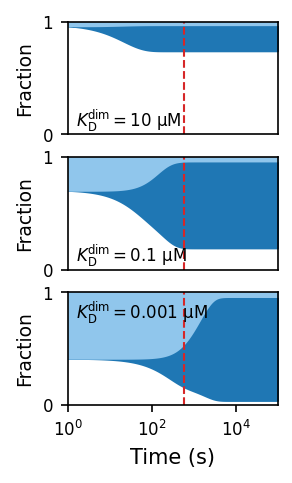

In [5]:
# Specify parameters
kn = 1.8
km = 2.5
ka_vals = [5, 7, 9]
tmin, tmax = 0, 5

# Evaluation timepoints
timepoints = 10 ** np.linspace(tmin, tmax, 501)

# Create empty results containers
sol0 = np.zeros([len(ka_vals), 3])
sol = np.zeros([len(ka_vals), len(timepoints), 3])
solinf = np.zeros([len(ka_vals), 3])

# Run simulations
for i, ka in enumerate(ka_vals):
    # Time zero
    sol0[i, :] = solve_equilibrium(km=1, ka=10**ka, kn=10**kn)

    # Timelapse
    sol[i, :, :] = solve_kinetic(
        km=10**km, ka=10**ka, kn=10**kn, x0=sol0[i, :], timepoints=timepoints
    )

    # Time infinity
    solinf[i, :] = solve_equilibrium(km=10**km, ka=10**ka, kn=10**kn)


# Create figure
fig, axs = plt.subplots(3, 1)
for i, (ax, s) in enumerate(zip(axs, sol)):
    ax.fill_between(x=np.log10(timepoints), y1=0, y2=s[:, 0] / dosage, color="w")
    ax.fill_between(
        x=np.log10(timepoints),
        y1=s[:, 0] / dosage,
        y2=s[:, 0] / dosage + s[:, 1] * svr * D / dosage,
        color="tab:blue",
    )
    ax.fill_between(
        x=np.log10(timepoints),
        y1=1,
        y2=1 - s[:, 2] * svr * D / dosage,
        color=lighten("tab:blue"),
    )
    ax.set_ylim(0, 1)
    ax.set_xlim(tmin, tmax)
    ax.set_ylabel("Fraction", fontsize=9)
    ax.set_yticks([0, 1])
    ax.tick_params(axis="x", labelsize=8)
    ax.tick_params(axis="y", labelsize=8)
    ax.axvline(np.log10(600), linestyle="--", c="tab:red", linewidth=1)


axs[0].text(
    x=tmin + 0.2,
    y=0.07,
    s=r"$K\mathrm{_D^{dim}}=%s$" % 10 ** (-ka_vals[0] + 6) + " µM",
    fontsize=8,
)
axs[1].text(
    x=tmin + 0.2,
    y=0.07,
    s=r"$K\mathrm{_D^{dim}}=%s$" % 10 ** (-ka_vals[1] + 6) + " µM",
    fontsize=8,
)
axs[2].text(
    x=tmin + 0.2,
    y=0.77,
    s=r"$K\mathrm{_D^{dim}}=%s$" % 10 ** (-ka_vals[2] + 6) + " µM",
    fontsize=8,
)
axs[0].set_xticks([])
axs[1].set_xticks([])
axs[2].xaxis.set_major_formatter(fake_log)
axs[2].set_xlabel("Time (s)")
# axs[0].set_title(r'$K\mathrm{_D^{mem}}=10^{%s}, K\mathrm{_D^{int}}=10^{%s}$' % (-km, -kn), fontsize=10, pad=15)
fig.set_size_inches(2, 3.5)
fig.subplots_adjust(left=0.2, bottom=0.15)
fig.savefig("Figs/timelapse.png", dpi=600, transparent=True)

### Pie chart grid

599.7910762555094
0.9999999999999999
0.9999999999999996
1.0000000000000004


1.000000000000001
0.9999999999999999
0.9999999999999998
1.0000000000000009
1.0
1.0000000000000007


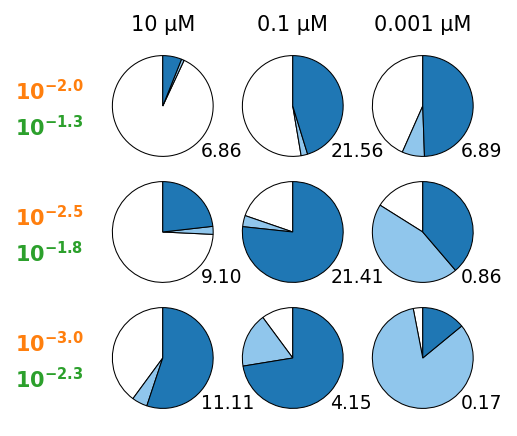

In [6]:
# Specify parameters
kas = [5, 7, 9]
kms = [2.0, 2.5, 3.0]

# Evaluation timepoints
timepoints = 10 ** np.linspace(0, 6, 1001)
a = np.argmin(abs(timepoints - 600))  # index representing 600s
print(timepoints[a])

# Empty results containers
sol0 = np.zeros([len(kms), len(kas), 3])
sol = np.zeros([len(kms), len(kas), 3])

# Run simulations
for i, km in enumerate(kms):
    for j, ka in enumerate(kas):
        sol0[i, j, :] = solve_equilibrium(km=1, ka=10**ka, kn=10 ** (km - 0.7))
        sol[i, j, :] = solve_kinetic(
            km=10**km,
            ka=10**ka,
            kn=10 ** (km - 0.7),
            x0=sol0[i, j, :],
            timepoints=timepoints,
        )[a]


# Create figure
def panel(ax, i, j):
    s = sol[i, j]
    c = s[0] / dosage
    m = s[1] * D * svr / dosage
    n = s[2] * D * svr / dosage
    print(c + m + n)
    ax.pie(
        [c, n, m],
        startangle=90,
        colors=["w", lighten("tab:blue"), "tab:blue"],
        wedgeprops={"linewidth": 0.5, "edgecolor": "k"},
    )
    ratio = m / n
    ax.text(0.75, -1, f"{ratio:.2f}", fontsize=9)


fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title("%s µM" % (10 ** (-kas[0] + 6)), fontsize=10)
ax[0][1].set_title("%s µM" % (10 ** (-kas[1] + 6)), fontsize=10)
ax[0][2].set_title("%s µM" % (10 ** (-kas[2] + 6)), fontsize=10)


def set_ylabel(ax, km):
    ylabel1 = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km),
        textprops=dict(
            color="tab:orange", size=10, rotation=0, ha="center", va="center"
        ),
    )
    ylabel2 = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km + 0.7),
        textprops=dict(
            color="tab:green", size=10, rotation=0, ha="center", va="center"
        ),
    )
    ylabel = VPacker(children=[ylabel1, ylabel2], align="center", pad=0, sep=5)
    anchored_ybox = AnchoredOffsetbox(
        loc=8,
        child=ylabel,
        pad=0.0,
        frameon=False,
        bbox_to_anchor=(-0.4, 0.3),
        bbox_transform=ax.transAxes,
        borderpad=0.0,
    )
    ax.add_artist(anchored_ybox)


set_ylabel(ax[0][0], kms[0])
set_ylabel(ax[1][0], kms[1])
set_ylabel(ax[2][0], kms[2])

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig("Figs/pie_mp.png", dpi=600, transparent=True)

### Pie chart grid - start

1.0
1.0
1.0
1.0
0.9999999999999999
0.9999999999999998
1.0
1.0
1.0


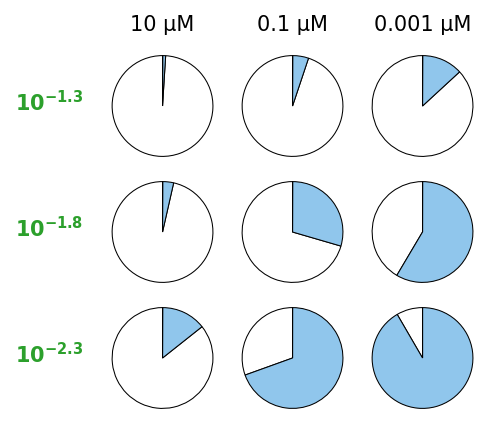

In [7]:
def panel(ax, i, j):
    s = sol0[i, j]
    c = s[0] / dosage
    m = s[1] * D * svr / dosage
    n = s[2] * D * svr / dosage
    print(c + m + n)
    ax.pie(
        [c, n, m],
        startangle=90,
        colors=["w", lighten("tab:blue"), "tab:blue"],
        wedgeprops={"linewidth": 0.5, "edgecolor": "k"},
    )


fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title("%s µM" % (10 ** (-kas[0] + 6)), fontsize=10)
ax[0][1].set_title("%s µM" % (10 ** (-kas[1] + 6)), fontsize=10)
ax[0][2].set_title("%s µM" % (10 ** (-kas[2] + 6)), fontsize=10)


def set_ylabel(ax, km):
    ylabel = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km + 0.7),
        textprops=dict(
            color="tab:green", size=10, rotation=0, ha="center", va="center"
        ),
    )
    anchored_ybox = AnchoredOffsetbox(
        loc=8,
        child=ylabel,
        pad=0.0,
        frameon=False,
        bbox_to_anchor=(-0.4, 0.5),
        bbox_transform=ax.transAxes,
        borderpad=0.0,
    )
    ax.add_artist(anchored_ybox)


set_ylabel(ax[0][0], kms[0])
set_ylabel(ax[1][0], kms[1])
set_ylabel(ax[2][0], kms[2])

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig("Figs/pie_pre_sb.png", dpi=600, transparent=True)

### Rates

In [8]:
# Grid resolution
resolution = 50

# Grid of equilibrium constants
ka_mem_vals = np.linspace(1.8, 3.2, resolution)
ka_int_vals = ka_mem_vals - 0.7
ka_dim_vals = np.linspace(4, 10, resolution)

# Empty results container
supp_eq_concs = np.zeros([resolution, resolution, 3])

# Solve (concentrations at t=0)
for i, (ka_mem, ka_int) in enumerate(zip(ka_mem_vals, ka_int_vals)):
    for j, ka_dim in enumerate(ka_dim_vals):
        supp_eq_concs[i, j, :] = solve_equilibrium(
            km=1, ka=10**ka_dim, kn=10**ka_int
        )

# fig, ax = plt.subplots()
# ax.imshow(supp_eq_concs[:, :, 1] /supp_eq_concs[:, :, 2])

In [9]:
# Evaluate on rate and off rates
supp_kon = kon(
    supp_eq_concs[:, :, 0], km=None, ka=10 ** ka_dim_vals[np.newaxis, ...], pf=pf
)
supp_koff_mem = koff(
    supp_eq_concs[:, :, 1],
    km=10 ** ka_mem_vals[..., np.newaxis],
    ka=10 ** ka_dim_vals[np.newaxis, ...],
    pf=pf,
)
supp_koff_int = koff(
    supp_eq_concs[:, :, 2],
    km=10 ** ka_int_vals[..., np.newaxis],
    ka=10 ** ka_dim_vals[np.newaxis, ...],
    pf=pf,
)

In [10]:
# Figures
def create_figure(array, title, filename=None):
    fig, ax = plt.subplots()
    fig.set_size_inches(3.2, 2.8)
    extent = (min(ka_dim_vals), max(ka_dim_vals), max(ka_int_vals), min(ka_int_vals))
    aspect = abs(extent[1] - extent[0]) / abs(extent[3] - extent[2])
    im = ax.imshow(np.log10(array), extent=extent, aspect=aspect, cmap="viridis")

    for ka in kas:
        for km in kms:
            ax.scatter(ka, km - 0.7, edgecolors="k", facecolors="w", s=10)

    @FuncFormatter
    def log_ka_to_kd(x, pos):
        return r"$10^{%.1f}$" % (-x)

    @FuncFormatter
    def log_ka_to_kd_molar_to_micromolar(x, pos):
        return r"$10^{%d}$" % (-x + 6)

    # Cbar
    cbar = fig.colorbar(im, fraction=0.046, pad=0.04)
    cbar.ax.tick_params(labelsize=6)
    cbar.ax.set_ylabel(title)

    ax.yaxis.set_major_formatter(log_ka_to_kd)
    ax.xaxis.set_major_formatter(log_ka_to_kd_molar_to_micromolar)
    ax.xaxis.tick_top()
    ax.set_yticks([i - 0.7 for i in kms])
    ax.set_yticklabels([])
    ax.set_xticks(kas)
    ax.set_xticklabels([])
    ax.xaxis.set_label_position("top")
    ax.tick_params(axis="both", labelsize=7)
    fig.subplots_adjust(left=0.22, top=0.8, right=0.8, bottom=0.05)

    if filename is not None:
        fig.savefig("Figs/" + filename, dpi=600, transparent=True)

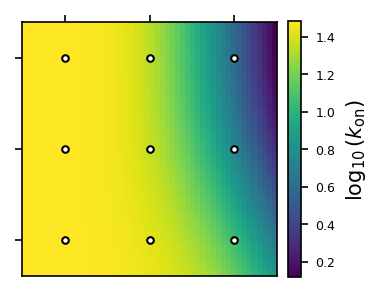

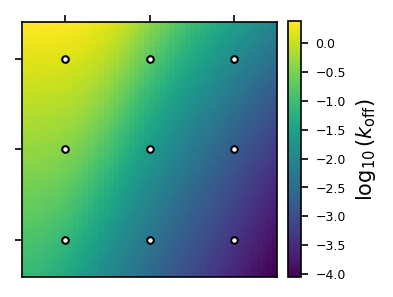

In [11]:
create_figure(supp_kon, r"$\log_{10}(k_\mathrm{{on}})$", "kon.png")
create_figure(supp_koff_int, r"$\log_{10}(k_\mathrm{{off}})$", "koff.png")

### Empty pie grid

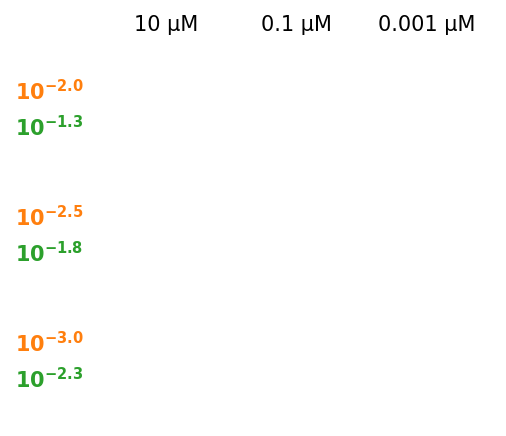

In [12]:
def panel(ax, i, j):
    ax.axis("off")


fig, ax = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        panel(ax[i][j], i, j)

ax[0][0].set_title("%s µM" % (10 ** (-kas[0] + 6)), fontsize=10)
ax[0][1].set_title("%s µM" % (10 ** (-kas[1] + 6)), fontsize=10)
ax[0][2].set_title("%s µM" % (10 ** (-kas[2] + 6)), fontsize=10)


def set_ylabel(ax, km):
    ylabel1 = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km),
        textprops=dict(
            color="tab:orange", size=10, rotation=0, ha="center", va="center"
        ),
    )
    ylabel2 = TextArea(
        r"$\mathbf{10^{%s}}$" % (-km + 0.7),
        textprops=dict(
            color="tab:green", size=10, rotation=0, ha="center", va="center"
        ),
    )
    ylabel = VPacker(children=[ylabel1, ylabel2], align="center", pad=0, sep=5)
    anchored_ybox = AnchoredOffsetbox(
        loc=8,
        child=ylabel,
        pad=0.0,
        frameon=False,
        bbox_to_anchor=(-0.4, 0.3),
        bbox_transform=ax.transAxes,
        borderpad=0.0,
    )
    ax.add_artist(anchored_ybox)


set_ylabel(ax[0][0], kms[0])
set_ylabel(ax[1][0], kms[1])
set_ylabel(ax[2][0], kms[2])

fig.set_size_inches(4, 2.8)
fig.subplots_adjust(wspace=-0.0, hspace=-0.0)
fig.subplots_adjust(left=0.3, right=0.95, top=0.9, bottom=0)
fig.savefig("Figs/pie_empty.png", dpi=600, transparent=True)

### Resistribution timescale

In [13]:
# Evaluation timepoints
timepoints = 10 ** np.linspace(0, 6, 1001)

# Empty results containers
sol_timescale = np.zeros([len(ka_mem_vals), len(ka_dim_vals)])
residuals = np.zeros([len(ka_mem_vals), len(ka_dim_vals)])

# Run simulations
for i, ka_mem in enumerate(ka_mem_vals):
    for j, ka_dim in enumerate(ka_dim_vals):
        # Kinetic simulation
        sol = solve_kinetic(
            km=10**ka_mem,
            ka=10**ka_dim,
            kn=10 ** (ka_mem - 0.7),
            x0=supp_eq_concs[i, j, :],
            timepoints=timepoints,
        ).T

        # Final equilibrium state
        sol_final = solve_equilibrium(
            km=10**ka_mem, ka=10**ka_dim, kn=10 ** (ka_mem - 0.7)
        )

        # 50/90% threshold concentrations
        conc50 = supp_eq_concs[i, j, 1] + 0.5 * (sol_final[1] - supp_eq_concs[i, j, 1])
        conc90 = supp_eq_concs[i, j, 1] + 0.9 * (sol_final[1] - supp_eq_concs[i, j, 1])

        # Calculate time to reach conc90
        sol_timescale[i, j] = timepoints[np.argmin(abs(sol[1, :] - conc90))]

        # Residuals
        residuals[i, j] = np.min(abs(sol[1, :] - conc50))

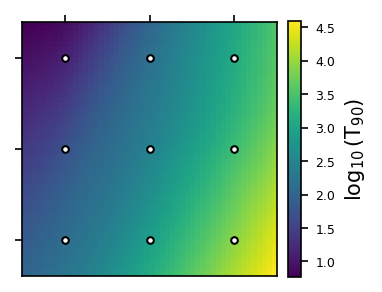

In [14]:
create_figure(sol_timescale, r"$\log_{10}({\rm T}_{90})$", "timescale.png")